# Torque Control

In [3]:
from kortex_api.autogen.client_stubs.ActuatorConfigClientRpc import ActuatorConfigClient
from kortex_api.autogen.client_stubs.ActuatorCyclicClientRpc import ActuatorCyclicClient
from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
from kortex_api.autogen.client_stubs.DeviceConfigClientRpc import DeviceConfigClient
from kortex_api.autogen.client_stubs.DeviceManagerClientRpc import DeviceManagerClient
from kortex_api.autogen.messages import Session_pb2, ActuatorConfig_pb2, Base_pb2, BaseCyclic_pb2, Common_pb2
from kortex_api.RouterClient import RouterClientSendOptions

import time
import sys
import threading

class TCPArguments:
    def __init__(self):
        self.ip = "192.168.0.10"
        self.username = "admin"
        self.password = "admin"

class TorqueExample:
    def __init__(self, router, router_real_time, torque_gain=2.0):

        # Maximum allowed waiting time during actions (in seconds)
        self.ACTION_TIMEOUT_DURATION = 20

        self.torque_amplification = torque_gain  # Torque measure on last actuator is sent as a command to first actuator

        # Create required services
        device_manager = DeviceManagerClient(router)
        
        self.actuator_config = ActuatorConfigClient(router)
        self.base = BaseClient(router)
        self.base_cyclic = BaseCyclicClient(router_real_time)

        self.base_command = BaseCyclic_pb2.Command()
        self.base_feedback = BaseCyclic_pb2.Feedback()
        self.base_custom_data = BaseCyclic_pb2.CustomData()

        # Detect all devices
        device_handles = device_manager.ReadAllDevices()
        self.actuator_count = self.base.GetActuatorCount().count

        # Only actuators are relevant for this example
        for handle in device_handles.device_handle:
            if handle.device_type == Common_pb2.BIG_ACTUATOR or handle.device_type == Common_pb2.SMALL_ACTUATOR:
                self.base_command.actuators.add()
                self.base_feedback.actuators.add()

        # Change send option to reduce max timeout at 3ms
        self.sendOption = RouterClientSendOptions()
        self.sendOption.andForget = False
        self.sendOption.delay_ms = 0
        self.sendOption.timeout_ms = 3

        self.cyclic_t_end = 30  #Total duration of the thread in seconds. 0 means infinite.
        self.cyclic_thread = {}

        self.kill_the_thread = False
        self.already_stopped = False
        self.cyclic_running = False

        # joint in control
        self.device_id = 3

        # Store the torque values
        self.time_stamp_sec = []
        self.first_link_torque = []

        # store impedance control parameters
        self._theta = []
        self._theta_dot = []
        self._theta_ddot = []
        self._theta_des = []
        self._tau = []

        # collision angle
        self.collision_angle = None

    # Create closure to set an event after an END or an ABORT
    def check_for_end_or_abort(self, e):
        """Return a closure checking for END or ABORT notifications

        Arguments:
        e -- event to signal when the action is completed
            (will be set when an END or ABORT occurs)
        """
        def check(notification, e = e):
            print("EVENT : " + \
                Base_pb2.ActionEvent.Name(notification.action_event))
            if notification.action_event == Base_pb2.ACTION_END \
            or notification.action_event == Base_pb2.ACTION_ABORT:
                e.set()
        return check

    def MoveToHomePosition(self):
        # Make sure the arm is in Single Level Servoing mode
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
    
        # Move arm to ready position
        print("Moving the arm to a safe position")
        action_type = Base_pb2.RequestedActionType()
        action_type.action_type = Base_pb2.REACH_JOINT_ANGLES
        action_list = self.base.ReadAllActions(action_type)
        action_handle = None
        for action in action_list.action_list:
            if action.name == "L_Home":
                action_handle = action.handle

        if action_handle == None:
            print("Can't reach safe position. Exiting")
            return False

        e = threading.Event()
        notification_handle = self.base.OnNotificationActionTopic(
            self.check_for_end_or_abort(e),
            Base_pb2.NotificationOptions()
        )

        self.base.ExecuteActionFromReference(action_handle)

        print("Waiting for movement to finish ...")
        finished = e.wait(self.ACTION_TIMEOUT_DURATION)
        self.base.Unsubscribe(notification_handle)

        if finished:
            print("Cartesian movement completed")
        else:
            print("Timeout on action notification wait")
        return finished

        return True

    def InitCyclic(self, sampling_time_cyclic=0.001, t_end=30, print_stats=False, target_func=None):

        if self.cyclic_running:
            return True

        # Move to Home position first
        if not self.MoveToHomePosition():
            return False

        print("Init Cyclic")
        sys.stdout.flush()

        base_feedback = self.SendCallWithRetry(self.base_cyclic.RefreshFeedback, 3)
        if base_feedback:
            self.base_feedback = base_feedback

            # Init command frame
            for x in range(self.actuator_count):
                self.base_command.actuators[x].flags = 1  # servoing
                self.base_command.actuators[x].position = self.base_feedback.actuators[x].position

            # First actuator is going to be controlled in torque
            # To ensure continuity, torque command is set to measure
            self.base_command.actuators[0].torque_joint = self.base_feedback.actuators[0].torque

            # Set arm in LOW_LEVEL_SERVOING
            base_servo_mode = Base_pb2.ServoingModeInformation()
            base_servo_mode.servoing_mode = Base_pb2.LOW_LEVEL_SERVOING
            self.base.SetServoingMode(base_servo_mode)

            # Send first frame
            self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)

            # Set first actuator in torque mode now that the command is equal to measure
            control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
            control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('TORQUE')
            # self.device_id = 3  # first actuator as id = 1

            self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)

            # Init cyclic thread
            self.cyclic_t_end = t_end
            self.cyclic_thread = threading.Thread(target=target_func, args=(sampling_time_cyclic, print_stats))
            self.cyclic_thread.daemon = True
            self.cyclic_thread.start()
            return True

        else:
            print("InitCyclic: failed to communicate")
            return False

    def RunCyclic(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0  # Counts refresh
        stats_count = 0  # Counts stats prints
        failed_cyclic_count = 0  # Count communication timeouts

        # Initial delta between first and last actuator
        init_delta_position = self.base_feedback.actuators[0].position - self.base_feedback.actuators[self.actuator_count - 1].position
        print("init_delta_position: ", init_delta_position)

        # Initial first and last actuator torques; avoids unexpected movement due to torque offsets
        init_last_torque = self.base_feedback.actuators[self.actuator_count - 1].torque
        init_first_torque = -self.base_feedback.actuators[self.device_id-1].torque  # Torque measure is reversed compared to actuator direction
        print("init_last_torque: ", init_last_torque)
        print("init_first_torque: ", init_first_torque)

        t_now = time.time()
        t_cyclic = t_now  # cyclic time
        t_stats = t_now  # print  time
        t_init = t_now  # init   time

        print("Running torque control example for {} seconds".format(self.cyclic_t_end))

        while not self.kill_the_thread:
            t_now = time.time()

            # Cyclic Refresh
            if (t_now - t_cyclic) >= t_sample:
                t_cyclic = t_now
                # Position command to first actuator is set to measured one to avoid following error to trigger
                # Bonus: When doing this instead of disabling the following error, if communication is lost and first
                #        actuator continue to move under torque command, resulting position error with command will
                #        trigger a following error and switch back the actuator in position command to hold its position

                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position
                # print("Running Position: ", self.base_command.actuators[0].position)

                # First actuator torque command is set to last actuator torque measure times an amplification
                # self.base_command.actuators[0].torque_joint = init_first_torque + \
                    # self.torque_amplification * (self.base_feedback.actuators[self.actuator_count - 1].torque - init_last_torque)

                print("Running Torque: ", self.base_feedback.actuators[self.device_id-1].torque)
                self.first_link_torque.append(self.base_feedback.actuators[self.device_id-1].torque)
                self.base_command.actuators[self.device_id-1].torque_joint = self.torque_amplification*self.base_feedback.actuators[self.device_id-1].torque
                self.time_stamp_sec.append(t_now-t_init)
                
                # self.base_command.actuators[0].torque_joint = init_first_torque + \
                #     self.torque_amplification * (self.base_feedback.actuators[0].torque - init_first_torque)

                # First actuator position is sent as a command to last actuator
                # self.base_command.actuators[self.actuator_count - 1].position = self.base_feedback.actuators[0].position - init_delta_position

                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True

    def StopCyclic(self):
        print ("Stopping the cyclic and putting the arm back in position mode...")
        if self.already_stopped:
            return

        # Kill the  thread first
        if self.cyclic_running:
            self.kill_the_thread = True
            self.cyclic_thread.join()
        
        # Set first actuator back in position mode
        control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
        control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('POSITION')
        # self.device_id = 1  # first actuator has id = 1
        self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)
        
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
        self.cyclic_t_end = 0.1

        self.already_stopped = True
        
        print('Clean Exit')

    @staticmethod
    def SendCallWithRetry(call, retry,  *args):
        i = 0
        arg_out = []
        while i < retry:
            try:
                arg_out = call(*args)
                break
            except:
                i = i + 1
                continue
        if i == retry:
            print("Failed to communicate")
        return arg_out
    
    def get_distance_to_target(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0  # Counts refresh
        stats_count = 0  # Counts stats prints
        failed_cyclic_count = 0  # Count communication timeouts

        # # Initial delta between first and last actuator
        # init_delta_position = self.base_feedback.actuators[0].position - self.base_feedback.actuators[self.actuator_count - 1].position
        # print("init_delta_position: ", init_delta_position)

        # # Initial first and last actuator torques; avoids unexpected movement due to torque offsets
        # init_last_torque = self.base_feedback.actuators[self.actuator_count - 1].torque
        # init_first_torque = -self.base_feedback.actuators[0].torque  # Torque measure is reversed compared to actuator direction
        # print("init_last_torque: ", init_last_torque)
        # print("init_first_torque: ", init_first_torque)

        t_now = time.time()
        t_cyclic = t_now  # cyclic time
        t_stats = t_now  # print  time
        t_init = t_now  # init   time
        t_impact = None

        impact_torque_threshold = 1.0
        impact_flag = False
        back_away_torque = 30.0
        back_away_time = 0.5
        impact_torque = -20.0
        impact_torque_time = 0.5

        print("Running torque control example for {} seconds".format(self.cyclic_t_end))

        while not self.kill_the_thread:
            t_now = time.time()

            # Cyclic Refresh
            if (t_now - t_cyclic) >= t_sample:
                t_cyclic = t_now
                # Position command to first actuator is set to measured one to avoid following error to trigger
                # Bonus: When doing this instead of disabling the following error, if communication is lost and first
                #        actuator continue to move under torque command, resulting position error with command will
                #        trigger a following error and switch back the actuator in position command to hold its position

                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position

                # print("Running Torque: ", self.base_feedback.actuators[0].torque+init_first_torque)

                # log torque and time
                current_torque = self.base_feedback.actuators[self.device_id-1].torque
                self.time_stamp_sec.append(t_now-t_init)


                self.first_link_torque.append(current_torque)
                if current_torque > impact_torque_threshold and t_now - t_init > impact_torque_time:
                    impact_flag = True
                    t_impact = t_now
                
                if impact_flag:
                    print("Impact detected, backing off")
                    if self.collision_angle is None:
                        self.collision_angle = self.base_feedback.actuators[self.device_id-1].position
                    self.base_command.actuators[self.device_id-1].torque_joint = back_away_torque  # Nm
                    if t_now - t_impact > back_away_time:
                        print("Back off complete")
                        back_away_torque = 0.0
                        self.base_command.actuators[self.device_id-1].torque_joint = back_away_torque
                else:
                    if t_now-t_init < impact_torque_time:
                        self.base_command.actuators[self.device_id-1].torque_joint = impact_torque  # Nm
                    
                print("joint_torque_command: ", self.base_command.actuators[self.device_id-1].torque_joint)
                
                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True
    

    def stiffness_control(self, theta, theta_dot, theta_des, k, b):
        # stiffness control example
        # theta: angle of the pendulum
        # theta_dot: angular velocity of the pendulum
        # k: spring constant
        # b: damping constant
        # m: mass of the pend
        # l: distance from the pivot to the center of mass of the arm
        # torque control equation: 
        # M(q)q_ddot + C(q, q_dot)q_dot + G(q) = tau
        
        tau = -k * (theta - theta_des) - b * theta_dot
        return tau
    

    def impedance_surface_bouncer(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0
        stats_count = 0
        failed_cyclic_count = 0

        t_now = time.time()
        t_cyclic = t_now
        t_stats = t_now
        t_init = t_now

        print("Running impedance bouncer example for {} seconds".format(self.cyclic_t_end))

        k = 5.0 # Nm/rad
        b = 0.1
        m = 0.5 
        l = 0.5

        init_theta = self.base_feedback.actuators[self.device_id-1].position

        while not self.kill_the_thread:
            t_now = time.time()

            if (t_now - t_cyclic) >= t_sample: # 1ms
                t_cyclic = t_now

                # Position command to avoid following error
                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position

                # log torque and time
                current_theta = self.base_feedback.actuators[self.device_id-1].position
                current_theta_dot = self.base_feedback.actuators[self.device_id-1].velocity
                self.time_stamp_sec.append(t_now-t_init)
                self._theta.append(current_theta)
                self._theta_dot.append(current_theta_dot)
                self._theta_des.append(init_theta)

                # calculate torque
                tau = self.stiffness_control(current_theta, current_theta_dot, init_theta, k, b)
                

                input_torque = self.torque_amplification * self.base_feedback.actuators[self.device_id-1].torque
                self.base_command.actuators[self.device_id-1].torque_joint = tau + input_torque
                self._tau.append(tau+input_torque)

                print("joint_torque_command: ", self.base_command.actuators[self.device_id-1].torque_joint)

                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True






In [4]:
# import utilities
# import matplotlib.pyplot as plt

# args = TCPArguments()
# t_log = []
# torque_log = []
# # Create connection to the device and get the router
# with utilities.DeviceConnection.createTcpConnection(args) as router, utilities.DeviceConnection.createUdpConnection(args) as router_real_time:

#     torque_example = TorqueExample(router, router_real_time, 3.0)


#     success = torque_example.InitCyclic(0.001, 30, True, torque_example.impedance_surface_bouncer)
#     if success:
#         while torque_example.cyclic_running:
#             try:
#                 time.sleep(0.1)
#             except KeyboardInterrupt:
#                 break

#         torque_example.StopCyclic()
#         t_log = torque_example.time_stamp_sec
#         torque_log = torque_example._tau

# # plot the torque
# plt.plot(t_log, torque_log)

# print("collision angle: ", torque_example.collision_angle)

## Test the calculation of Pinocchio Lib

In [47]:
# display current path
import os, sys
from pathlib import Path
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pinocchio as pin
import utilities
curr_path = Path().resolve()
sys.path.append(str(curr_path))
from impedance_ctrl_testing import SpringMassOscillationModel
from tool_box_no_ros import rotation_matrix_to_euler, get_world_EE_HomoMtx, get_joint_angles

class TCPArguments:
    def __init__(self):
        self.ip = "192.168.0.10"
        self.username = "admin"
        self.password = "admin"

# get the joint angle and velocity in low level servoing mode
args = TCPArguments() 
p_model = SpringMassOscillationModel()

def get_realtime_q_qdot(base_feedback):
    # will convert from degrees to radians
    joint_angles = [joint.position for joint in base_feedback.actuators]
    joint_velocities = [joint.velocity for joint in base_feedback.actuators]
    return np.radians(joint_angles), np.radians(joint_velocities)

with utilities.DeviceConnection.createTcpConnection(args) as router, utilities.DeviceConnection.createUdpConnection(args) as router_real_time:
    torque_example = TorqueExample(router, router_real_time, 3.0)
    base_feedback = torque_example.SendCallWithRetry(torque_example.base_cyclic.RefreshFeedback, 3)
    base = torque_example.base
    q, qdot = get_realtime_q_qdot(base_feedback)
    print(f"q: {np.degrees(q)}")
    # get end effector pose
    x_current = base_feedback.base.tool_pose_x
    y_current = base_feedback.base.tool_pose_y
    z_current = base_feedback.base.tool_pose_z
    theta_x = base_feedback.base.tool_pose_theta_x
    theta_y = base_feedback.base.tool_pose_theta_y
    theta_z = base_feedback.base.tool_pose_theta_z
    p_ee = np.array([x_current, y_current, z_current, theta_x, theta_y, theta_z])
    print(f"p_ee: {p_ee}")

    q_pin = p_model.standard_to_pinocchio(q)
    # q_back = p_model.pinocchio_to_standard(q_pin)
    # print(f"q_back: {q_back.T}")
    # forward kinematics
    p_cal = p_model.get_end_effector_pose(q_pin)
    T = p_model.data.oMf[p_model.EE_frame_id]
    H_ee = get_world_EE_HomoMtx(base)
    R_ee = H_ee[:3, :3]
    print(f"p_cal: {p_cal.T}")
    # print(f"rpy_tb: {np.degrees(rotation_matrix_to_euler(R_ee))}")
    M, C, G = p_model.get_robot_dynamics(q_pin, qdot)
    print(f"M:\n {M}")
    print(f"C: {C}")
    print(f"G: {G}")
    # pin_q = np.zeros()
    print(f"q: {q_pin.T}")

    # print joint torque limits
    # joint_limit_h = torque_example.control_config.GetAllKinematicSoftLimits()
    # joint_limit_s = base.GetAllJointsTorqueSoftLimitation()
    # print(f"joint_limit_hard: {joint_limit_h}")
    # print(f"joint_limit_soft: {joint_limit_s}")

print("q and qdot: ", q, qdot)
print(p_model.model)
# print("M: ", M)
# print("C: ", C)
# print("G: ", G)
    
    


Logging as admin on device 192.168.0.10
Logging as admin on device 192.168.0.10
q: [ 89.9985 269.9978 179.8858   0.003  359.993  330.0033 269.9937]
p_ee: [  0.0075   0.8829   0.3702  59.7529  -0.6235 179.7569]
p_cal: [   0.0015    0.8802    0.3685   60.0081   -0.1263 -179.9956]
M:
 [[ 1.3954  0.0003 -0.0322 -0.0013 -0.0323 -0.0005  0.0002]
 [ 0.0003  1.3955  0.0265 -0.4935  0.0014 -0.0588  0.    ]
 [-0.0322  0.0265  0.0058 -0.0106  0.0033 -0.0014  0.0002]
 [-0.0013 -0.4935 -0.0106  0.2201 -0.0012  0.0305 -0.    ]
 [-0.0323  0.0014  0.0033 -0.0012  0.0033 -0.0005  0.0002]
 [-0.0005 -0.0588 -0.0014  0.0305 -0.0005  0.0093 -0.    ]
 [ 0.0002  0.      0.0002 -0.      0.0002 -0.      0.0002]]
C: [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
G: [-0.1735  0.3792 -0.     -0.3803  0.     -0.3807  0.0002]
q: [ 0.      1.      4.7124 -1.      0.002   0.0001  1.     -0.0001  5

In [17]:
# display all joint short names
print("List of frame names in the model:")
for frame in p_model.data.oMi:
    print(frame)



List of frame names in the model:
  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
           1 -1.11853e-05  -2.7629e-18
-1.11853e-05           -1  7.34641e-06
-8.21716e-11 -7.34641e-06           -1
  p =       0       0 0.15643

  R =
           1  6.92426e-06  1.11853e-05
-1.11854e-05  1.10195e-05            1
 6.92414e-06           -1  1.10196e-05
  p = -6.01209e-08  -0.00537594      0.28481

  R =
          1 4.26103e-06 6.92422e-06
4.26098e-06          -1 7.34633e-06
6.92425e-06 -7.3463e-06          -1
  p = -1.58815e-06   -0.0117533      0.49519

  R =
           1  1.33158e-05 -4.26106e-06
 4.26091e-06  1.10196e-05            1
 1.33158e-05           -1  1.10195e-05
  p = -3.01771e-06   -0.0181298      0.70557

  R =
           1 -8.68191e-05  1.33158e-05
-8.68192e-05           -1  7.34636e-06
 1.33152e-05 -7.34752e-06           -1
  p = -5.76595e-06   -0.0245071        0.914

  R =
           1   2.5034e-05  8.68191e-05
-8.68193e-05  1.10185e-05            1
 2.50331e-05           -

In [18]:
for frame in p_model.data.oMf:
    print(frame)

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

  R =
           1   4.2078e-05 -2.50337e-05
-4.20782e-05            1 -7.34534e-06
 2.50334e-05   7.3464e-06            1
  p = -1.13989e-05   -0.0248596      1.18738

  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0



### Testing for Pinnochio Gravity Compensation

Logging as admin on device 192.168.0.10
Logging as admin on device 192.168.0.10
Moving the arm to a safe position
Waiting for movement to finish ...
EVENT : ACTION_START
EVENT : ACTION_FEEDBACK
EVENT : ACTION_END
Cartesian movement completed
Init Cyclic
Run Cyclic


Exception in thread Thread-57 (gravity_compensated_compliance):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3858604/2053367339.py", line 271, in gravity_compensated_compliance
  File "/workspaces/isaac_ros-dev/src/ros2_kinova_ws/src/gen3_7dof/gen3_7dof/tool_box_no_ros.py", line 295, in get_realtime_q_qdot
    joint_angles = [joint.value for joint in base_feedback.joint_angles]
AttributeError: joint_angles


Running gravity_compensated_compliance for 10 seconds
Stopping the cyclic and putting the arm back in position mode...
Clean Exit


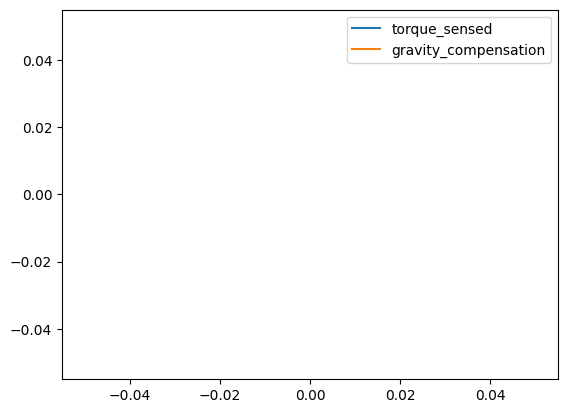

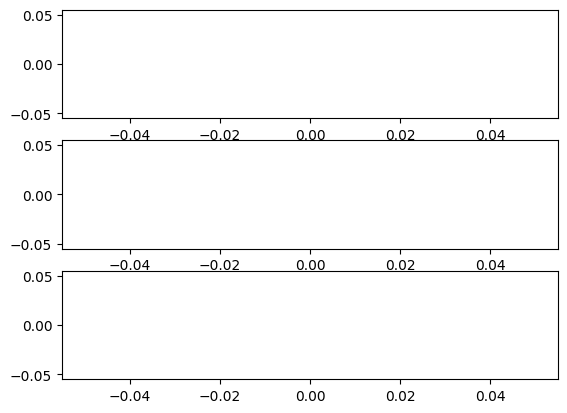

In [15]:
from kortex_api.autogen.client_stubs.ActuatorConfigClientRpc import ActuatorConfigClient
from kortex_api.autogen.client_stubs.ActuatorCyclicClientRpc import ActuatorCyclicClient
from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
from kortex_api.autogen.client_stubs.DeviceConfigClientRpc import DeviceConfigClient
from kortex_api.autogen.client_stubs.DeviceManagerClientRpc import DeviceManagerClient
from kortex_api.autogen.messages import Session_pb2, ActuatorConfig_pb2, Base_pb2, BaseCyclic_pb2, Common_pb2
from kortex_api.RouterClient import RouterClientSendOptions

from pathlib import Path
curr_path = Path().resolve()
sys.path.append(str(curr_path))
from impedance_ctrl_testing import SpringMassOscillationModel

import numpy as np
np.set_printoptions(precision=4, suppress=True)


import time
import sys
import threading

class TCPArguments:
    def __init__(self):
        self.ip = "192.168.0.10"
        self.username = "admin"
        self.password = "admin"

class TorqueExample:
    def __init__(self, router, router_real_time, torque_gain=2.0):

        # Maximum allowed waiting time during actions (in seconds)
        self.ACTION_TIMEOUT_DURATION = 20

        self.torque_amplification = torque_gain  # Torque measure on last actuator is sent as a command to first actuator

        # Create required services
        device_manager = DeviceManagerClient(router)
        
        self.actuator_config = ActuatorConfigClient(router)
        self.base = BaseClient(router)
        self.base_cyclic = BaseCyclicClient(router_real_time)

        self.base_command = BaseCyclic_pb2.Command()
        self.base_feedback = BaseCyclic_pb2.Feedback()
        self.base_custom_data = BaseCyclic_pb2.CustomData()

        # Detect all devices
        device_handles = device_manager.ReadAllDevices()
        self.actuator_count = self.base.GetActuatorCount().count

        # Only actuators are relevant for this example
        for handle in device_handles.device_handle:
            if handle.device_type == Common_pb2.BIG_ACTUATOR or handle.device_type == Common_pb2.SMALL_ACTUATOR:
                self.base_command.actuators.add()
                self.base_feedback.actuators.add()

        # Change send option to reduce max timeout at 3ms
        self.sendOption = RouterClientSendOptions()
        self.sendOption.andForget = False
        self.sendOption.delay_ms = 0
        self.sendOption.timeout_ms = 3

        self.cyclic_t_end = 30  #Total duration of the thread in seconds. 0 means infinite.
        self.cyclic_thread = {}

        self.kill_the_thread = False
        self.already_stopped = False
        self.cyclic_running = False

        # joint in control
        self.device_id = 3

        # Store the torque values
        self.time_stamp_sec = []
        self.first_link_torque = []

        # store impedance control parameters
        self._theta = []
        self._theta_dot = []
        self._theta_ddot = []
        self._theta_des = []
        self._tau = []
        self._gravity = []
        self._computation_time = []


        # collision angle
        self.collision_angle = None

    # Create closure to set an event after an END or an ABORT
    def check_for_end_or_abort(self, e):
        """Return a closure checking for END or ABORT notifications

        Arguments:
        e -- event to signal when the action is completed
            (will be set when an END or ABORT occurs)
        """
        def check(notification, e = e):
            print("EVENT : " + \
                Base_pb2.ActionEvent.Name(notification.action_event))
            if notification.action_event == Base_pb2.ACTION_END \
            or notification.action_event == Base_pb2.ACTION_ABORT:
                e.set()
        return check

    def MoveToHomePosition(self):
        # Make sure the arm is in Single Level Servoing mode
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
    
        # Move arm to ready position
        print("Moving the arm to a safe position")
        action_type = Base_pb2.RequestedActionType()
        action_type.action_type = Base_pb2.REACH_JOINT_ANGLES
        action_list = self.base.ReadAllActions(action_type)
        action_handle = None
        for action in action_list.action_list:
            # if action.name == "L_Home":
            if action.name == "L_Up":
                action_handle = action.handle

        if action_handle == None:
            print("Can't reach safe position. Exiting")
            return False

        e = threading.Event()
        notification_handle = self.base.OnNotificationActionTopic(
            self.check_for_end_or_abort(e),
            Base_pb2.NotificationOptions()
        )

        self.base.ExecuteActionFromReference(action_handle)

        print("Waiting for movement to finish ...")
        finished = e.wait(self.ACTION_TIMEOUT_DURATION)
        self.base.Unsubscribe(notification_handle)

        if finished:
            print("Cartesian movement completed")
        else:
            print("Timeout on action notification wait")
        return finished

        return True

    def InitCyclic(self, sampling_time_cyclic=0.001, t_end=30, print_stats=False, target_func=None):

        if self.cyclic_running:
            return True

        # Move to Home position first
        if not self.MoveToHomePosition():
            return False

        print("Init Cyclic")
        sys.stdout.flush()

        base_feedback = self.SendCallWithRetry(self.base_cyclic.RefreshFeedback, 3)
        if base_feedback:
            self.base_feedback = base_feedback

            # Init command frame
            for x in range(self.actuator_count):
                self.base_command.actuators[x].flags = 1  # servoing
                self.base_command.actuators[x].position = self.base_feedback.actuators[x].position

            # First actuator is going to be controlled in torque
            # To ensure continuity, torque command is set to measure
            self.base_command.actuators[0].torque_joint = self.base_feedback.actuators[0].torque

            # Set arm in LOW_LEVEL_SERVOING
            base_servo_mode = Base_pb2.ServoingModeInformation()
            base_servo_mode.servoing_mode = Base_pb2.LOW_LEVEL_SERVOING
            self.base.SetServoingMode(base_servo_mode)

            # Send first frame
            self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)

            # Set first actuator in torque mode now that the command is equal to measure
            control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
            control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('TORQUE')
            # self.device_id = 3  # first actuator as id = 1

            self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)

            # Init cyclic thread
            self.cyclic_t_end = t_end
            self.cyclic_thread = threading.Thread(target=target_func, args=(sampling_time_cyclic, print_stats))
            self.cyclic_thread.daemon = True
            self.cyclic_thread.start()
            return True

        else:
            print("InitCyclic: failed to communicate")
            return False


    def StopCyclic(self):
        print ("Stopping the cyclic and putting the arm back in position mode...")
        if self.already_stopped:
            return

        # Kill the  thread first
        if self.cyclic_running:
            self.kill_the_thread = True
            self.cyclic_thread.join()
        
        # Set first actuator back in position mode
        control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
        control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('POSITION')
        # self.device_id = 1  # first actuator has id = 1
        self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)
        
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
        self.cyclic_t_end = 0.1

        self.already_stopped = True
        
        print('Clean Exit')

    @staticmethod
    def SendCallWithRetry(call, retry,  *args):
        i = 0
        arg_out = []
        while i < retry:
            try:
                arg_out = call(*args)
                break
            except:
                i = i + 1
                continue
        if i == retry:
            print("Failed to communicate")
        return arg_out
    

    def gravity_compensated_compliance(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0
        stats_count = 0
        failed_cyclic_count = 0

        t_now = time.time()
        t_cyclic = t_now
        t_stats = t_now
        t_init = t_now

        previous_tau = 0.0
        previous_theta_dot = 0.0

        print("Running gravity_compensated_compliance for {} seconds".format(self.cyclic_t_end))


        init_theta = self.base_feedback.actuators[self.device_id-1].position

        while not self.kill_the_thread:
            t_now = time.time()

            if (t_now - t_cyclic) >= t_sample: # 1ms
                t_cyclic = t_now
                # Position command to avoid following error
                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position

                # get the current joint angle and velocity for pinocchio model
                q, qdot = get_realtime_q_qdot(self.base_feedback)
                q_pin = p_model.standard_to_pinocchio(q)
                M, C, G = p_model.get_robot_dynamics(q_pin, qdot)
                g_actuator = G[self.device_id-1]
                print(f"g_actuator: {g_actuator}")
                self._gravity.append(g_actuator)

                # log torque and time
                current_theta = self.base_feedback.actuators[self.device_id-1].position
                current_theta_dot = self.base_feedback.actuators[self.device_id-1].velocity
                self.time_stamp_sec.append(t_now-t_init)
                self._theta.append(current_theta)
                self._theta_dot.append(current_theta_dot)
                self._theta_des.append(init_theta)
                self._theta_ddot.append((current_theta_dot-previous_theta_dot)/t_sample)

                previous_theta_dot = current_theta_dot

                # calculate torque
                tau = 0.0
                
                # need to remove the torque measured from the actuation
                # input_torque = (self.base_feedback.actuators[self.device_id-1].torque+tau)
                input_torque = 5.0  # Nm

                self.base_command.actuators[self.device_id-1].torque_joint = tau + input_torque
                self._tau.append(input_torque)

                print("joint_torque_command: ", self.base_command.actuators[self.device_id-1].torque_joint)
                previous_tau = input_torque

                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1
                self._computation_time.append(time.time()-t_now)

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True


import matplotlib.pyplot as plt

args = TCPArguments()
t_log = []
torque_log = []
# Create connection to the device and get the router
with utilities.DeviceConnection.createTcpConnection(args) as router, utilities.DeviceConnection.createUdpConnection(args) as router_real_time:

    torque_example = TorqueExample(router, router_real_time, 3.0)


    success = torque_example.InitCyclic(0.001, 10, True, torque_example.gravity_compensated_compliance)
    if success:
        while torque_example.cyclic_running:
            try:
                time.sleep(0.1)
            except KeyboardInterrupt:
                break

        torque_example.StopCyclic()
        t_log = torque_example.time_stamp_sec
        torque_log = torque_example._tau

# plot the torque
plt.plot(t_log, torque_log, label="torque_sensed")
plt.plot(t_log, torque_example._gravity, label="gravity_compensation")
plt.legend()

# another plot with subplots
fig, axs = plt.subplots(3, 1)
axs[0].plot(t_log, torque_example._theta, label="theta")
axs[1].plot(t_log, torque_example._theta_dot, label="theta_dot")
axs[2].plot(t_log, torque_example._theta_ddot, label="theta_ddot")


In [20]:
# get the torque after 2.5 seconds
import numpy as np
t_log = np.array(t_log)
torque_log = np.array(torque_log)
idx = np.where(t_log > 2.5)[0]
print(f"torque after 2.5 seconds: {np.mean(torque_log[idx])}")

torque after 2.5 seconds: -0.0028083680083674715


### Testing pyKinovaGen3 lib

In [13]:
"""Position level forward kinematics for Kinova Gen3

Functions
---------
forward_kinematics(joint_position)

"""

import math
import numpy


def forward_kinematics(q):
    """
    Position level forward kinematics of the Kinova Gen3 robot

    Arguments
    ---------
    joint_position (array_like): The joint angles of the robot

    Returns
    -------
    ndarray: The end-effector position
    ndarray: The rotation matrix of the end-effector

    """

    q1 = q[0]
    q2 = q[1]
    q3 = q[2]
    q4 = q[3]
    q5 = q[4]
    q6 = q[5]
    q7 = q[6]

    x0 = math.sin(q1)
    x1 = math.cos(q3)
    x2 = x0 * x1
    x3 = math.cos(q1)
    x4 = math.sin(q2)
    x5 = x3 * x4
    x6 = math.cos(q4)
    x7 = x5 * x6
    x8 = math.cos(q2)
    x9 = math.sin(q3)
    x10 = x3 * x9
    x11 = x10 * x8
    x12 = math.cos(q5)
    x13 = x11 + x2
    x14 = x12 * x13
    x15 = math.sin(q4)
    x16 = x0 * x9
    x17 = x1 * x3
    x18 = -x16 + x17 * x8
    x19 = x15 * x18
    x20 = math.sin(q5)
    x21 = -x15 * x5 + x18 * x6
    x22 = x20 * x21
    x23 = math.cos(q6)
    x24 = -x19 - x7
    x25 = x23 * x24
    x26 = math.sin(q6)
    x27 = x12 * x21 - x13 * x20
    x28 = x26 * x27
    x29 = x0 * x4
    x30 = x29 * x6
    x31 = x16 * x8
    x32 = x17 - x31
    x33 = x12 * x32
    x34 = -x10 - x2 * x8
    x35 = x15 * x34
    x36 = x15 * x29 + x34 * x6
    x37 = x20 * x36
    x38 = x30 - x35
    x39 = x23 * x38
    x40 = x12 * x36 - x20 * x32
    x41 = x26 * x40
    x42 = x4 * x9
    x43 = x6 * x8
    x44 = x12 * x42
    x45 = x1 * x4
    x46 = x15 * x45
    x47 = -x43 + x46
    x48 = x23 * x47
    x49 = -x15 * x8 - x45 * x6
    x50 = x20 * x49
    x51 = x12 * x49 + x20 * x42
    x52 = x26 * x51
    x53 = math.sin(q7)
    x54 = x14 + x22
    x55 = math.cos(q7)
    x56 = x23 * x27 + x24 * x26
    x57 = x33 + x37
    x58 = x23 * x40 + x26 * x38
    x59 = -x44 + x50
    x60 = x23 * x51 + x26 * x47

    position = numpy.array(
        [
            [
                -0.01175 * x0
                - 0.01275 * x11
                - 0.0003501 * x14
                + 0.31436 * x19
                - 0.01275 * x2
                - 0.0003501 * x22
                - 0.16743 * x25
                + 0.16743 * x28
                + 0.42076 * x5
                + 0.31436 * x7
            ],
            [
                -0.01275 * x17
                - 0.42076 * x29
                - 0.01175 * x3
                - 0.31436 * x30
                + 0.01275 * x31
                - 0.0003501 * x33
                + 0.31436 * x35
                - 0.0003501 * x37
                - 0.16743 * x39
                + 0.16743 * x41
            ],
            [
                0.01275 * x42
                + 0.31436 * x43
                + 0.0003501 * x44
                - 0.31436 * x46
                - 0.16743 * x48
                - 0.0003501 * x50
                + 0.16743 * x52
                + 0.42076 * x8
                + 0.28481
            ],
        ]
    ).flatten()
    
    rotation = numpy.array(
        [
            [-x53 * x54 + x55 * x56, x53 * x56 + x54 * x55, -x25 + x28],
            [-x53 * x57 + x55 * x58, x53 * x58 + x55 * x57, -x39 + x41],
            [-x53 * x59 + x55 * x60, x53 * x60 + x55 * x59, -x48 + x52],
        ]
    )

    return position, rotation

In [15]:
import os, sys
from pathlib import Path
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import utilities
curr_path = Path().resolve()
sys.path.append(str(curr_path))
from tool_box_no_ros import get_joint_angles, H_mtx_to_kinova_pose_in_base

class TCPArguments:
    def __init__(self):
        self.ip = "192.168.0.10"
        self.username = "admin"
        self.password = "admin"

# get the joint angle and velocity in low level servoing mode
args = TCPArguments() 

def get_realtime_q_qdot(base_feedback):
    # will convert from degrees to radians
    joint_angles = [joint.position for joint in base_feedback.actuators]
    joint_velocities = [joint.velocity for joint in base_feedback.actuators]
    return np.radians(joint_angles), np.radians(joint_velocities)

with utilities.DeviceConnection.createTcpConnection(args) as router, utilities.DeviceConnection.createUdpConnection(args) as router_real_time:
    torque_example = TorqueExample(router, router_real_time, 3.0)
    base_feedback = torque_example.SendCallWithRetry(torque_example.base_cyclic.RefreshFeedback, 3)
    q, qdot = get_realtime_q_qdot(base_feedback)
    print(f"q: {np.degrees(q)}")
    # get end effector pose
    x_current = base_feedback.base.tool_pose_x
    y_current = base_feedback.base.tool_pose_y
    z_current = base_feedback.base.tool_pose_z
    theta_x = base_feedback.base.tool_pose_theta_x
    theta_y = base_feedback.base.tool_pose_theta_y
    theta_z = base_feedback.base.tool_pose_theta_z
    p_ee = np.array([x_current, y_current, z_current, theta_x, theta_y, theta_z])
    print(f"p_ee: {p_ee}")

    # q_pin = p_model.standard_to_pinocchio(q)
    # q_back = p_model.pinocchio_to_standard(q_pin)
    # print(f"q_back: {q_back.T}")
    # forward kinematics
    p_cal, R_cal = forward_kinematics(q)
    H_cal = np.eye(4)
    H_cal[:3, :3] = R_cal
    H_cal[:3, 3] = p_cal
    p_cal = H_mtx_to_kinova_pose_in_base(H_cal)
    print(f"p_cal: {p_cal}")
    # M, C, G = p_model.get_robot_dynamics(q_pin, qdot)
    # print(f"M: {M}")
    # print(f"C: {C}")
    # print(f"G: {G}")
    # # pin_q = np.zeros()
    # print(f"q: {q_pin.T}")
    

print("q and qdot: ", q, qdot)
# print("M: ", M)
# print("C: ", C)
# print("G: ", G)

Logging as admin on device 192.168.0.10
Logging as admin on device 192.168.0.10
q: [ 0.544  72.2204  0.0143 18.0432  0.0058 50.5291  0.0299]
p_ee: [  0.823   -0.0241   0.281  179.6666  39.3015 179.5981]
p_cal: [   0.8206   -0.0327    0.2821 -179.9505   39.2072  179.5061]
q and qdot:  [0.0095 1.2605 0.0002 0.3149 0.0001 0.8819 0.0005] [ 0. -0.  0.  0.  0.  0.  0.]


### Testing for Friction Reduction

In [2]:
from kortex_api.autogen.client_stubs.ActuatorConfigClientRpc import ActuatorConfigClient
from kortex_api.autogen.client_stubs.ActuatorCyclicClientRpc import ActuatorCyclicClient
from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
from kortex_api.autogen.client_stubs.DeviceConfigClientRpc import DeviceConfigClient
from kortex_api.autogen.client_stubs.DeviceManagerClientRpc import DeviceManagerClient
from kortex_api.autogen.messages import Session_pb2, ActuatorConfig_pb2, Base_pb2, BaseCyclic_pb2, Common_pb2
from kortex_api.RouterClient import RouterClientSendOptions
from kortex_api.autogen.client_stubs.ControlConfigClientRpc import ControlConfigClient

from pathlib import Path
import sys
curr_path = Path().resolve()
sys.path.append(str(curr_path))
from impedance_ctrl_testing import SpringMassOscillationModel
from tool_box_no_ros import get_realtime_q_qdot, LowPassFilter, get_realtime_torque
import utilities
# import copy
from copy import deepcopy

import numpy as np
np.set_printoptions(precision=4, suppress=True)


import time
import sys
import threading

p_model = SpringMassOscillationModel()

class TCPArguments:
    def __init__(self):
        self.ip = "192.168.0.10"
        self.username = "admin"
        self.password = "admin"

class TorqueExample:
    def __init__(self, router, router_real_time, Home_pose="L_Home", actuator_id = 7):

        # Maximum allowed waiting time during actions (in seconds)
        self.ACTION_TIMEOUT_DURATION = 20

        self.torque_amplification = 1.0  # Torque measure on last actuator is sent as a command to first actuator
        self.Home_pose = Home_pose

        # Create required services
        device_manager = DeviceManagerClient(router)
        
        self.actuator_config = ActuatorConfigClient(router)
        self.base = BaseClient(router)
        self.base_cyclic = BaseCyclicClient(router_real_time)
        self.control_config = ControlConfigClient(router)

        self.base_command = BaseCyclic_pb2.Command()
        self.base_feedback = BaseCyclic_pb2.Feedback()
        self.base_custom_data = BaseCyclic_pb2.CustomData()

        # Detect all devices
        device_handles = device_manager.ReadAllDevices()
        self.actuator_count = self.base.GetActuatorCount().count

        # Only actuators are relevant for this example
        for handle in device_handles.device_handle:
            if handle.device_type == Common_pb2.BIG_ACTUATOR or handle.device_type == Common_pb2.SMALL_ACTUATOR:
                self.base_command.actuators.add()
                self.base_feedback.actuators.add()

        # Change send option to reduce max timeout at 3ms
        self.sendOption = RouterClientSendOptions()
        self.sendOption.andForget = False
        self.sendOption.delay_ms = 0
        self.sendOption.timeout_ms = 3

        self.cyclic_t_end = 30  #Total duration of the thread in seconds. 0 means infinite.
        self.cyclic_thread = {}

        self.kill_the_thread = False
        self.already_stopped = False
        self.cyclic_running = False

        # joint in control
        self.device_id = actuator_id

        # Store the torque values
        self.time_stamp_sec = []
        self.first_link_torque = []

        # store impedance result parameters
        self._theta = []
        self._theta_dot = []
        self._theta_ddot = []
        self._theta_des = []
        self._q = []
        self._q_dot = []

        self._tau = []
        self._gravity = []
        self._computation_time = []
        self._filtered_tau = []
        self._task_tau = []
        self._friction_tau = []

        # parameters for impedance control based on https://github.com/empriselab/gen3_compliant_controllers/blob/main/media/controller_formulation.pdf
        self.motor_joint_stiffness = np.diag([4000, 4000, 4000, 4000, 3500, 3500, 3500]) # Nm/rad
        self.motor_joint_Kp = 2.0* np.diag([20, 20, 20, 20, 10, 10, 10])  # motor joint stiffness gain
        # self.motor_joint_Kp = np.diag([40, 40, 40, 10, 5, 5, 5])  # motor joint stiffness gain (calibrated for compliance)

        self.motor_joint_Kd = np.diag([2, 2, 2, 2, 2, 2, 2])  # motor joint damping gain

        # self.motor_inertia = np.diag([0.3, 0.3, 0.3, 0.3, 0.18, 0.18, 0.18])  # kg.m^2
        self.motor_inertia = np.diag([0.08, 0.08, 0.08, 0.08, 0.10, 0.10, 0.10])  # kg.m^2

        self.motor_friction_l = 3.0 * np.diag([25, 25, 25, 25, 20, 20, 20]) # friction observor velocity gain 
        # self.motor_friction_l = np.diag([75, 75, 75, 75, 50, 50, 50]) # friction observor position gain (calibrated for compliance)

        self.motor_friction_lp = 0.1* np.diag([2.5, 2.5, 2.5, 2.5, 2, 2, 2]) # friction observor position gain 
        # self.motor_friction_lp = np.diag([0.25, 0.25, 0.25, 0.25, 0.2, 0.2, 0.2]) # friction observor position gain (calibrated for compliance)

        self.joint_torque_limit = np.array([50, 50, 50, 50, 30, 30, 30])  # Nm soft limit

        # filter for torque measurement
        self.torque_lowpass = []

        # collision angle
        self.collision_angle = None

    # Create closure to set an event after an END or an ABORT
    def check_for_end_or_abort(self, e):
        """Return a closure checking for END or ABORT notifications

        Arguments:
        e -- event to signal when the action is completed
            (will be set when an END or ABORT occurs)
        """
        def check(notification, e = e):
            print("EVENT : " + \
                Base_pb2.ActionEvent.Name(notification.action_event))
            if notification.action_event == Base_pb2.ACTION_END \
            or notification.action_event == Base_pb2.ACTION_ABORT:
                e.set()
        return check

    def MoveToHomePosition(self):
        # Make sure the arm is in Single Level Servoing mode
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
    
        # Move arm to ready position
        print("Moving the arm to a safe position")
        action_type = Base_pb2.RequestedActionType()
        action_type.action_type = Base_pb2.REACH_JOINT_ANGLES
        action_list = self.base.ReadAllActions(action_type)
        action_handle = None
        for action in action_list.action_list:
            # if action.name == "L_Home":
            if action.name == self.Home_pose:
                action_handle = action.handle

        if action_handle == None:
            print("Can't reach safe position. Exiting")
            return False

        e = threading.Event()
        notification_handle = self.base.OnNotificationActionTopic(
            self.check_for_end_or_abort(e),
            Base_pb2.NotificationOptions()
        )

        self.base.ExecuteActionFromReference(action_handle)

        print("Waiting for movement to finish ...")
        finished = e.wait(self.ACTION_TIMEOUT_DURATION)
        self.base.Unsubscribe(notification_handle)

        if finished:
            print("Cartesian movement completed")
        else:
            print("Timeout on action notification wait")
        return finished


    def InitCyclic(self, sampling_time_cyclic=0.001, t_end=30, print_stats=False, target_func=None):

        if self.cyclic_running:
            return True

        # Move to Home position first
        if not self.MoveToHomePosition():
            return False

        print("Init Cyclic")
        sys.stdout.flush()

        base_feedback = self.SendCallWithRetry(self.base_cyclic.RefreshFeedback, 3)
        if base_feedback:
            self.base_feedback = base_feedback

            # Init command frame
            for x in range(self.actuator_count):
                self.base_command.actuators[x].flags = 1  # servoing
                self.base_command.actuators[x].position = self.base_feedback.actuators[x].position

            # First actuator is going to be controlled in torque
            # To ensure continuity, torque command is set to measure
            self.base_command.actuators[0].torque_joint = self.base_feedback.actuators[0].torque

            # Set arm in LOW_LEVEL_SERVOING
            base_servo_mode = Base_pb2.ServoingModeInformation()
            base_servo_mode.servoing_mode = Base_pb2.LOW_LEVEL_SERVOING
            self.base.SetServoingMode(base_servo_mode)

            # Send first frame
            self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)

            # Set first actuator in torque mode now that the command is equal to measure
            control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
            control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('TORQUE')
            # self.device_id = 3  # first actuator as id = 1

            self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)

            # Init cyclic thread
            self.cyclic_t_end = t_end
            self.cyclic_thread = threading.Thread(target=target_func, args=(sampling_time_cyclic, print_stats))
            self.cyclic_thread.daemon = True
            self.cyclic_thread.start()
            return True

        else:
            print("InitCyclic: failed to communicate")
            return False


    def StopCyclic(self):
        print ("Stopping the cyclic and putting the arm back in position mode...")
        if self.already_stopped:
            return

        # Kill the  thread first
        if self.cyclic_running:
            self.kill_the_thread = True
            self.cyclic_thread.join()
        
        # Set first actuator back in position mode
        control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
        control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('POSITION')
        # self.device_id = 1  # first actuator has id = 1
        self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)
        
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
        self.cyclic_t_end = 0.1

        self.already_stopped = True
        
        print('Clean Exit')

    @staticmethod
    def SendCallWithRetry(call, retry,  *args):
        i = 0
        arg_out = []
        while i < retry:
            try:
                arg_out = call(*args)
                break
            except:
                i = i + 1
                continue
        if i == retry:
            print("Failed to communicate")
        return arg_out
    

    def friction_compensated_compliance(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0
        stats_count = 0
        failed_cyclic_count = 0

        t_now = time.time()
        t_cyclic = t_now
        t_stats = t_now
        t_init = t_now

        # init_theta = self.base_feedback.actuators[self.device_id-1].position
        init_q, init_qdot = get_realtime_q_qdot(self.base_feedback)
        init_torque = get_realtime_torque(self.base_feedback)
        
        previous_nominal_theta = init_q # nominal motor angle
        previous_nominal_theta_dot = init_qdot  # nominal motor velocity

        K_s_inv = np.linalg.inv(self.motor_joint_stiffness)
        K_r_inv = np.linalg.inv(self.motor_inertia) # motor inertia

    
        self.torque_lowpass = LowPassFilter(init_torque,cutoff_freq=10)
        self.velocity_lowpass = LowPassFilter(init_qdot, cutoff_freq=10)
        #Initialization was incorrect. with multi channel


        print("Running friction compensation for {} seconds".format(self.cyclic_t_end))

        while not self.kill_the_thread:
            t_now = time.time()

            if (t_now - t_cyclic) >= t_sample: # 1ms
                t_cyclic = t_now
                # Position command to avoid following error
                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position

                # get the current joint angle and velocity for pinocchio model
                q, qdot_raw = get_realtime_q_qdot(self.base_feedback)
                qdot = self.velocity_lowpass.filter(qdot_raw)


                q_pin = p_model.standard_to_pinocchio(q)
                M, C, G = p_model.get_robot_dynamics(q_pin, qdot)
                # notice that G is the force that the motor needs to apply to counteract gravity not the gravity itself
                g_actuator = G[self.device_id-1]
                self._gravity.append(g_actuator)

                # get torque measurement
                tau_full = get_realtime_torque(self.base_feedback)
                tau_full = self.torque_lowpass.filter(tau_full)
                tau_measured = self.base_feedback.actuators[self.device_id-1].torque
                tau_filtered = tau_full[self.device_id-1]

                #### with target impedance #####
                # q_des = deepcopy(init_q)
                # q_des[self.device_id-1] = 1.0  # rad

                ##### Compliant control #####
                q_des = q



                qdot_des = qdot

                # setting up friction observer
                # print(f"gravity effect on theta_des: {K_s_inv @ G}")
                theta_des = q_des - K_s_inv @ G
                theta_dot_des = qdot_des
                # print(f"theta_des, theta_dot_des: {theta_des[0]}, {theta_dot_des[0]}")

                # print(f"prev_n_theta, theta_des, prev_n_theta_dot, theta_dot_des: {previous_nominal_theta[0]}, {theta_des[0]}, {previous_nominal_theta_dot[0]}, {theta_dot_des[0]}")
                # handling the angle difference at boundaries
                theta_diff = (previous_nominal_theta - theta_des + np.pi) % (2 * np.pi) - np.pi  # wrap to -pi to pi
                # print(f"theta_diff: {theta_diff[self.device_id-1]}")

                tau_task = -self.motor_joint_Kp @ (theta_diff) - self.motor_joint_Kd @ (previous_nominal_theta_dot - theta_dot_des)
                nominal_theta_ddot = K_r_inv @ (tau_task - G - tau_full)
                nominal_theta_dot = previous_nominal_theta_dot + t_sample * nominal_theta_ddot
                nominal_theta = previous_nominal_theta + t_sample * nominal_theta_dot
                # print(f"tau_task, nthdd, nthd, nth: {tau_task[0]}, {nominal_theta_ddot[0]}, {nominal_theta_dot[0]}, {nominal_theta[0]}")

                # update previous values
                previous_nominal_theta = nominal_theta
                previous_nominal_theta_dot = nominal_theta_dot

                # nominal friction
                # print(f"n_th_d, qdot, n_th, q: {nominal_theta_dot[0]}, {qdot[0]}, {nominal_theta[0]}, {q[0]}")
                # handling the angle difference at boundaries
                observer_theta_diff = (nominal_theta - q + np.pi) % (2 * np.pi) - np.pi
                tau_friction = self.motor_inertia @ self.motor_friction_l @ ((nominal_theta_dot - qdot) + self.motor_friction_lp @ (observer_theta_diff))
                # print(f"task, friction, ddot, dot, theta: {tau_task[0]}, {tau_friction[0]}, {nominal_theta_ddot[0]}, {nominal_theta_dot[0]}, {nominal_theta[0]}")
                # tau = tau_task + tau_friction


                # # log torque and time
    
                self._theta.append(nominal_theta)
                self._theta_dot.append(nominal_theta_dot*180/np.pi)
                self._theta_des.append(theta_des)
                self._theta_ddot.append(nominal_theta_ddot)
                self._q.append(q)
                self._q_dot.append(qdot*180/np.pi)
                self._filtered_tau.append(tau_full)
                
                self._task_tau.append(tau_task)
                self._friction_tau.append(tau_friction)



                # need to remove the torque measured from the actuation
                # input_torque = (self.base_feedback.actuators[self.device_id-1].torque + G[self.device_id-1])

                ################## observer friction compensation#####################
                input_torque = tau_task[self.device_id-1] + tau_friction[self.device_id-1] + G[self.device_id-1] # Nm
                
                # input_torque = np.clip(input_torque, -self.joint_torque_limit[self.device_id-1], self.joint_torque_limit[self.device_id-1])


                self.base_command.actuators[self.device_id-1].torque_joint = input_torque
                self._tau.append(input_torque)

                # print("meas, task, friction, grav: ", tau_measured, tau_task[self.device_id-1], tau_friction[self.device_id-1], g_actuator)
            

                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1
                self.time_stamp_sec.append(t_now-t_init)
                self._computation_time.append(time.time()-t_now)

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True


import matplotlib.pyplot as plt

args = TCPArguments()
t_log = []
torque_log = []
# Create connection to the device and get the router
with utilities.DeviceConnection.createTcpConnection(args) as router, utilities.DeviceConnection.createUdpConnection(args) as router_real_time:

    torque_example = TorqueExample(router, router_real_time, Home_pose="L_Down", actuator_id= 1)
    # torque_example = TorqueExample(router, router_real_time, Home_pose="L_Back", actuator_id= 3)


    success = torque_example.InitCyclic(0.001, 60, True, torque_example.friction_compensated_compliance)
    if success:
        while torque_example.cyclic_running:
            try:
                time.sleep(0.1)
            except KeyboardInterrupt:
                break

        torque_example.StopCyclic()
        t_log = torque_example.time_stamp_sec
        torque_log = torque_example._tau


Logging as admin on device 192.168.0.10
Logging as admin on device 192.168.0.10
Moving the arm to a safe position
Waiting for movement to finish ...
EVENT : ACTION_START
EVENT : ACTION_END
Cartesian movement completed
Init Cyclic
Run Cyclic
Running friction compensation for 60 seconds
Cyclic Finished
Stopping the cyclic and putting the arm back in position mode...
Clean Exit


In [4]:
print(torque_example.motor_inertia @ torque_example.motor_friction_l)
print(torque_example._tau)
# plt.plot(t_log, torque_example._filtered_tau, label="filtered_tau") 

[[7.5 0.  0.  0.  0.  0.  0. ]
 [0.  7.5 0.  0.  0.  0.  0. ]
 [0.  0.  7.5 0.  0.  0.  0. ]
 [0.  0.  0.  7.5 0.  0.  0. ]
 [0.  0.  0.  0.  3.6 0.  0. ]
 [0.  0.  0.  0.  0.  3.6 0. ]
 [0.  0.  0.  0.  0.  0.  3.6]]
[-11.410343110635397, -11.319653442329917, -11.22864227054775, -11.137270954224908, -11.045408793004812, -10.953221069280469, -10.860918213710738, -10.768430478941864, -10.675828049666986, -10.58315697317678, -10.490519440054502, -10.39801194138362, -10.305593246949345, -10.21335091270304, -10.121299790337757, -10.029555407306487, -9.938166047957132, -9.847153094552414, -9.75648368000747, -9.666185657307643, -9.576282527200792, -9.486803618790345, -9.397778123679418, -9.309229325554467, -9.221191436410162, -9.133679545766942, -9.04665946966898, -8.960139488951818, -8.874147710719967, -8.78870393153451, -8.703853863046142, -8.619575366168007, -8.535785728997979, -8.452477431504622, -8.369690023740983, -8.287357146332193, -8.205368983602764, -8.123705612108154, -8.042300057

device_id: 3


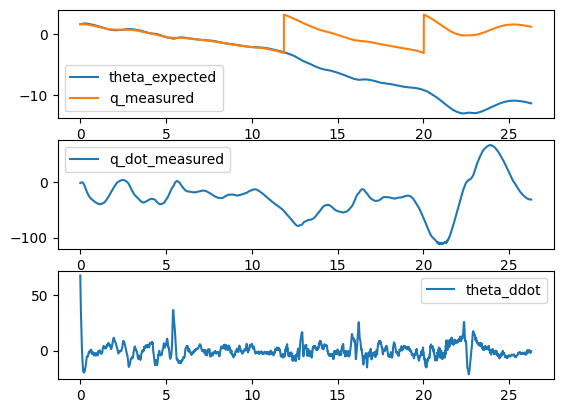

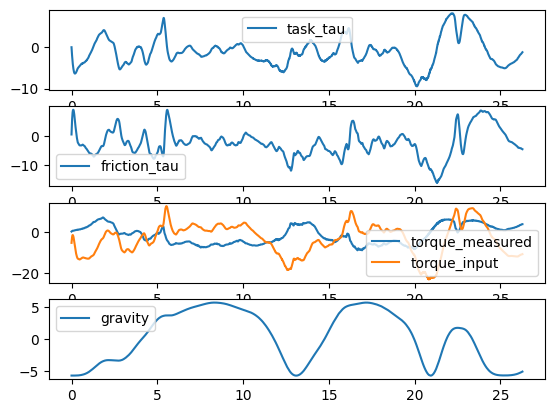

In [16]:

# # plot the torque
# plt.plot(t_log, torque_log, label="torque_sensed")
# plt.plot(t_log, torque_example._filtered_tau, label="torque_filtered")
# plt.plot(t_log, torque_example._computation_time, label="computation_time")
# plt.plot(t_log, torque_example._gravity, label="gravity_compensation")
# plt.legend()
dev_id = torque_example.device_id
print(f"device_id: {dev_id}")
# # another plot with subplots
fig, axs = plt.subplots(3, 1)
axs[0].plot(t_log, np.array(torque_example._theta).T[dev_id-1], label="theta_expected")
axs[0].plot(t_log, np.array(torque_example._q).T[dev_id-1], label="q_measured")
axs[0].legend()
# axs[1].plot(t_log, np.array(torque_example._theta_dot).T[dev_id-1], label="theta_dot_expected")
axs[1].plot(t_log, np.array(torque_example._q_dot).T[dev_id-1], label="q_dot_measured")
axs[1].legend()
axs[2].plot(t_log, np.array(torque_example._theta_ddot).T[dev_id-1], label="theta_ddot")
axs[2].legend()

# another plot for task and friction torque
fig, axs = plt.subplots(4, 1)
axs[0].plot(t_log, np.array(torque_example._task_tau).T[dev_id-1], label="task_tau")
axs[0].legend()
axs[1].plot(t_log, np.array(torque_example._friction_tau).T[dev_id-1], label="friction_tau")
axs[1].legend()
axs[2].plot(t_log, np.array(torque_example._filtered_tau).T[dev_id-1], label="torque_measured")
axs[2].plot(t_log, np.array(torque_example._tau), label="torque_input")
axs[2].legend()
axs[3].plot(t_log, torque_example._gravity, label="gravity")
axs[3].legend()

# testing gravity compensation


In [5]:
torque_example.torque_lowpass.alpha

0.08613019954354688

In [ ]:
# from kortex_api.autogen.client_stubs.ActuatorConfigClientRpc import ActuatorConfigClient
# from kortex_api.autogen.client_stubs.ActuatorCyclicClientRpc import ActuatorCyclicClient
# from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
# from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
# from kortex_api.autogen.client_stubs.DeviceConfigClientRpc import DeviceConfigClient
# from kortex_api.autogen.client_stubs.DeviceManagerClientRpc import DeviceManagerClient
# from kortex_api.autogen.messages import Session_pb2, ActuatorConfig_pb2, Base_pb2, BaseCyclic_pb2, Common_pb2
# from kortex_api.RouterClient import RouterClientSendOptions
# from kortex_api.autogen.client_stubs.ControlConfigClientRpc import ControlConfigClient

# from pathlib import Path
# import sys
# curr_path = Path().resolve()
# sys.path.append(str(curr_path))
# from impedance_ctrl_testing import SpringMassOscillationModel
# from tool_box_no_ros import get_realtime_q_qdot, LowPassFilter, get_realtime_torque
# import utilities
# # import copy
# from copy import deepcopy

# import numpy as np
# np.set_printoptions(precision=4, suppress=True)


# import time
# import sys
# import threading

# p_model = SpringMassOscillationModel()

# class TCPArguments:
#     def __init__(self):
#         self.ip = "192.168.0.10"
#         self.username = "admin"
#         self.password = "admin"

# class TorqueExample:
#     def __init__(self, router, router_real_time, Home_pose="L_Home", actuator_id = 7):

#         # Maximum allowed waiting time during actions (in seconds)
#         self.ACTION_TIMEOUT_DURATION = 20

#         self.torque_amplification = 1.0  # Torque measure on last actuator is sent as a command to first actuator
#         self.Home_pose = Home_pose

#         # Create required services
#         device_manager = DeviceManagerClient(router)
        
#         self.actuator_config = ActuatorConfigClient(router)
#         self.base = BaseClient(router)
#         self.base_cyclic = BaseCyclicClient(router_real_time)
#         self.control_config = ControlConfigClient(router)

#         self.base_command = BaseCyclic_pb2.Command()
#         self.base_feedback = BaseCyclic_pb2.Feedback()
#         self.base_custom_data = BaseCyclic_pb2.CustomData()

#         # Detect all devices
#         device_handles = device_manager.ReadAllDevices()
#         self.actuator_count = self.base.GetActuatorCount().count

#         # Only actuators are relevant for this example
#         for handle in device_handles.device_handle:
#             if handle.device_type == Common_pb2.BIG_ACTUATOR or handle.device_type == Common_pb2.SMALL_ACTUATOR:
#                 self.base_command.actuators.add()
#                 self.base_feedback.actuators.add()

#         # Change send option to reduce max timeout at 3ms
#         self.sendOption = RouterClientSendOptions()
#         self.sendOption.andForget = False
#         self.sendOption.delay_ms = 0
#         self.sendOption.timeout_ms = 3

#         self.cyclic_t_end = 30  #Total duration of the thread in seconds. 0 means infinite.
#         self.cyclic_thread = {}

#         self.kill_the_thread = False
#         self.already_stopped = False
#         self.cyclic_running = False

#         # joint in control
#         self.device_id = actuator_id

#         # Store the torque values
#         self.time_stamp_sec = []
#         self.first_link_torque = []

#         # store impedance result parameters
#         self._theta = []
#         self._theta_dot = []
#         self._theta_ddot = []
#         self._theta_des = []
#         self._q = []
#         self._q_dot = []

#         self._tau = []
#         self._gravity = []
#         self._computation_time = []
#         self._filtered_tau = []
#         self._task_tau = []
#         self._friction_tau = []

#         # parameters for impedance control based on https://github.com/empriselab/gen3_compliant_controllers/blob/main/media/controller_formulation.pdf
#         self.motor_joint_stiffness = np.diag([4000, 4000, 4000, 4000, 3500, 3500, 3500]) # Nm/rad
#         self.motor_joint_Kp = np.diag([20, 20, 20, 20, 10, 10, 10])  # motor joint stiffness gain
#         self.motor_joint_Kd = 3.0* np.diag([2, 2, 2, 2, 2, 2, 2])  # motor joint damping gain
#         self.motor_inertia = np.diag([0.3, 0.3, 0.3, 0.3, 0.18, 0.18, 0.18])  # kg.m^2
#         self.motor_friction_l = 3.0 * np.diag([25, 25, 25, 25, 20, 20, 20]) # friction observor proportional gain
#         self.motor_friction_lp = np.diag([5, 5, 5, 5, 4, 4, 4])  # friction observor derivative gain

#         self.joint_torque_limit = np.array([50, 50, 50, 50, 30, 30, 30])  # Nm soft limit

#         # filter for torque measurement
#         self.torque_lowpass = []

#         # collision angle
#         self.collision_angle = None

#     # Create closure to set an event after an END or an ABORT
#     def check_for_end_or_abort(self, e):
#         """Return a closure checking for END or ABORT notifications

#         Arguments:
#         e -- event to signal when the action is completed
#             (will be set when an END or ABORT occurs)
#         """
#         def check(notification, e = e):
#             print("EVENT : " + \
#                 Base_pb2.ActionEvent.Name(notification.action_event))
#             if notification.action_event == Base_pb2.ACTION_END \
#             or notification.action_event == Base_pb2.ACTION_ABORT:
#                 e.set()
#         return check

#     def MoveToHomePosition(self):
#         # Make sure the arm is in Single Level Servoing mode
#         base_servo_mode = Base_pb2.ServoingModeInformation()
#         base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
#         self.base.SetServoingMode(base_servo_mode)
    
#         # Move arm to ready position
#         print("Moving the arm to a safe position")
#         action_type = Base_pb2.RequestedActionType()
#         action_type.action_type = Base_pb2.REACH_JOINT_ANGLES
#         action_list = self.base.ReadAllActions(action_type)
#         action_handle = None
#         for action in action_list.action_list:
#             # if action.name == "L_Home":
#             if action.name == self.Home_pose:
#                 action_handle = action.handle

#         if action_handle == None:
#             print("Can't reach safe position. Exiting")
#             return False

#         e = threading.Event()
#         notification_handle = self.base.OnNotificationActionTopic(
#             self.check_for_end_or_abort(e),
#             Base_pb2.NotificationOptions()
#         )

#         self.base.ExecuteActionFromReference(action_handle)

#         print("Waiting for movement to finish ...")
#         finished = e.wait(self.ACTION_TIMEOUT_DURATION)
#         self.base.Unsubscribe(notification_handle)

#         if finished:
#             print("Cartesian movement completed")
#         else:
#             print("Timeout on action notification wait")
#         return finished


#     def InitCyclic(self, sampling_time_cyclic=0.001, t_end=30, print_stats=False, target_func=None):

#         if self.cyclic_running:
#             return True

#         # Move to Home position first
#         if not self.MoveToHomePosition():
#             return False

#         print("Init Cyclic")
#         sys.stdout.flush()

#         base_feedback = self.SendCallWithRetry(self.base_cyclic.RefreshFeedback, 3)
#         if base_feedback:
#             self.base_feedback = base_feedback

#             # Init command frame
#             for x in range(self.actuator_count):
#                 self.base_command.actuators[x].flags = 1  # servoing
#                 self.base_command.actuators[x].position = self.base_feedback.actuators[x].position

#             # First actuator is going to be controlled in torque
#             # To ensure continuity, torque command is set to measure
#             self.base_command.actuators[0].torque_joint = self.base_feedback.actuators[0].torque

#             # Set arm in LOW_LEVEL_SERVOING
#             base_servo_mode = Base_pb2.ServoingModeInformation()
#             base_servo_mode.servoing_mode = Base_pb2.LOW_LEVEL_SERVOING
#             self.base.SetServoingMode(base_servo_mode)

#             # Send first frame
#             self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)

#             # Set first actuator in torque mode now that the command is equal to measure
#             control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
#             control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('TORQUE')
#             # self.device_id = 3  # first actuator as id = 1

#             self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)

#             # Init cyclic thread
#             self.cyclic_t_end = t_end
#             self.cyclic_thread = threading.Thread(target=target_func, args=(sampling_time_cyclic, print_stats))
#             self.cyclic_thread.daemon = True
#             self.cyclic_thread.start()
#             return True

#         else:
#             print("InitCyclic: failed to communicate")
#             return False


#     def StopCyclic(self):
#         print ("Stopping the cyclic and putting the arm back in position mode...")
#         if self.already_stopped:
#             return

#         # Kill the  thread first
#         if self.cyclic_running:
#             self.kill_the_thread = True
#             self.cyclic_thread.join()
        
#         # Set first actuator back in position mode
#         control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
#         control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('POSITION')
#         # self.device_id = 1  # first actuator has id = 1
#         self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)
        
#         base_servo_mode = Base_pb2.ServoingModeInformation()
#         base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
#         self.base.SetServoingMode(base_servo_mode)
#         self.cyclic_t_end = 0.1

#         self.already_stopped = True
        
#         print('Clean Exit')

#     @staticmethod
#     def SendCallWithRetry(call, retry,  *args):
#         i = 0
#         arg_out = []
#         while i < retry:
#             try:
#                 arg_out = call(*args)
#                 break
#             except:
#                 i = i + 1
#                 continue
#         if i == retry:
#             print("Failed to communicate")
#         return arg_out
    

#     def friction_compensated_compliance(self, t_sample, print_stats):
#         self.cyclic_running = True
#         print("Run Cyclic")
#         sys.stdout.flush()
#         cyclic_count = 0
#         stats_count = 0
#         failed_cyclic_count = 0

#         t_now = time.time()
#         t_cyclic = t_now
#         t_stats = t_now
#         t_init = t_now

#         # init_theta = self.base_feedback.actuators[self.device_id-1].position
#         init_q, init_qdot = get_realtime_q_qdot(self.base_feedback)
#         init_torque = get_realtime_torque(self.base_feedback)
        
#         previous_nominal_theta = init_q # nominal motor angle
#         previous_nominal_theta_dot = init_qdot  # nominal motor velocity

#         K_s_inv = np.linalg.inv(self.motor_joint_stiffness)
#         K_r_inv = np.linalg.inv(self.motor_inertia) # motor inertia

    
#         self.torque_lowpass = LowPassFilter(init_torque,cutoff_freq=5)
#         self.velocity_lowpass = LowPassFilter(init_qdot, cutoff_freq=5)
#         #Initialization was incorrect. with multi channel


#         print("Running friction compensation for {} seconds".format(self.cyclic_t_end))

#         while not self.kill_the_thread:
#             t_now = time.time()

#             if (t_now - t_cyclic) >= t_sample: # 1ms
#                 t_cyclic = t_now
#                 # Position command to avoid following error
#                 self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position

#                 # get the current joint angle and velocity for pinocchio model
#                 q, qdot_raw = get_realtime_q_qdot(self.base_feedback)
#                 qdot = self.velocity_lowpass.filter(qdot_raw)


#                 q_pin = p_model.standard_to_pinocchio(q)
#                 M, C, G = p_model.get_robot_dynamics(q_pin, qdot)
#                 g_actuator = G[self.device_id-1]
#                 self._gravity.append(g_actuator)

#                 # get torque measurement
#                 tau_full = get_realtime_torque(self.base_feedback)
#                 tau_full = self.torque_lowpass.filter(tau_full)
#                 tau_measured = self.base_feedback.actuators[self.device_id-1].torque
#                 tau_filtered = tau_full[self.device_id-1]

#                 q_des = deepcopy(q)
#                 # q_des[self.device_id-1] = 1.0  # rad
#                 qdot_des = qdot

#                 # setting up friction observer
#                 theta_des = q_des + K_s_inv @ G
#                 theta_dot_des = qdot_des
#                 # print(f"theta_des, theta_dot_des: {theta_des[0]}, {theta_dot_des[0]}")

#                 # print(f"prev_n_theta, theta_des, prev_n_theta_dot, theta_dot_des: {previous_nominal_theta[0]}, {theta_des[0]}, {previous_nominal_theta_dot[0]}, {theta_dot_des[0]}")
#                 # handling the angle difference at boundaries
#                 theta_diff = (previous_nominal_theta - theta_des + np.pi) % (2 * np.pi) - np.pi  # wrap to -pi to pi
#                 print(f"theta_diff: {theta_diff[self.device_id-1]}")

#                 tau_task = -self.motor_joint_Kp @ (theta_diff) - self.motor_joint_Kd @ (previous_nominal_theta_dot - theta_dot_des)
#                 nominal_theta_ddot = K_r_inv @ (tau_task -G - tau_full)
#                 nominal_theta_dot = previous_nominal_theta_dot + t_sample * nominal_theta_ddot
#                 nominal_theta = previous_nominal_theta + t_sample * nominal_theta_dot
#                 # print(f"tau_task, nthdd, nthd, nth: {tau_task[0]}, {nominal_theta_ddot[0]}, {nominal_theta_dot[0]}, {nominal_theta[0]}")

#                 # update previous values
#                 previous_nominal_theta = nominal_theta
#                 previous_nominal_theta_dot = nominal_theta_dot

#                 # nominal friction
#                 # print(f"n_th_d, qdot, n_th, q: {nominal_theta_dot[0]}, {qdot[0]}, {nominal_theta[0]}, {q[0]}")
#                 # handling the angle difference at boundaries
#                 observer_theta_diff = (nominal_theta - q + np.pi) % (2 * np.pi) - np.pi
#                 tau_friction = self.motor_inertia @ self.motor_friction_l @ ((nominal_theta_dot - qdot) + self.motor_friction_lp @ (observer_theta_diff))
#                 # print(f"task, friction, ddot, dot, theta: {tau_task[0]}, {tau_friction[0]}, {nominal_theta_ddot[0]}, {nominal_theta_dot[0]}, {nominal_theta[0]}")
#                 # tau = tau_task + tau_friction


#                 # # log torque and time
    
#                 self._theta.append(nominal_theta)
#                 self._theta_dot.append(nominal_theta_dot)
#                 self._theta_des.append(theta_des)
#                 self._theta_ddot.append(nominal_theta_ddot)
#                 self._q.append(q)
#                 self._q_dot.append(qdot)
#                 self._filtered_tau.append(tau_full)
                
#                 self._task_tau.append(tau_task)
#                 self._friction_tau.append(tau_friction)


#                 # calculate torque
#                 tau = 0.0
                
#                 # need to remove the torque measured from the actuation
#                 # input_torque = (self.base_feedback.actuators[self.device_id-1].torque+tau)
#                 input_torque = g_actuator - tau_friction[self.device_id-1]  # Nm

#                 input_torque = np.clip(input_torque, -self.joint_torque_limit[self.device_id-1], self.joint_torque_limit[self.device_id-1])

#                 self.base_command.actuators[self.device_id-1].torque_joint = input_torque
#                 self._tau.append(input_torque)

#                 # print("meas, task, friction, grav: ", tau_measured, tau_task[self.device_id-1], tau_friction[self.device_id-1], g_actuator)
            

#                 # Incrementing identifier ensure actuators can reject out of time frames
#                 self.base_command.frame_id += 1
#                 if self.base_command.frame_id > 65535:
#                     self.base_command.frame_id = 0
#                 for i in range(self.actuator_count):
#                     self.base_command.actuators[i].command_id = self.base_command.frame_id

#                 # Frame is sent
#                 try:
#                     self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
#                 except:
#                     failed_cyclic_count = failed_cyclic_count + 1
#                 cyclic_count = cyclic_count + 1
#                 self.time_stamp_sec.append(t_now-t_init)
#                 self._computation_time.append(time.time()-t_now)

#             # Stats Print
#             if print_stats and ((t_now - t_stats) > 1):
#                 t_stats = t_now
#                 stats_count = stats_count + 1
                
#                 cyclic_count = 0
#                 failed_cyclic_count = 0
#                 sys.stdout.flush()

#             if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
#                 print("Cyclic Finished")
#                 sys.stdout.flush()
#                 break
#         self.cyclic_running = False
#         return True


# import matplotlib.pyplot as plt

# args = TCPArguments()
# t_log = []
# torque_log = []
# # Create connection to the device and get the router
# with utilities.DeviceConnection.createTcpConnection(args) as router, utilities.DeviceConnection.createUdpConnection(args) as router_real_time:

#     torque_example = TorqueExample(router, router_real_time, Home_pose="L_Down", actuator_id= 1)


#     success = torque_example.InitCyclic(0.001, 60, True, torque_example.friction_compensated_compliance)
#     if success:
#         while torque_example.cyclic_running:
#             try:
#                 time.sleep(0.1)
#             except KeyboardInterrupt:
#                 break

#         torque_example.StopCyclic()
#         t_log = torque_example.time_stamp_sec
#         torque_log = torque_example._tau


### Below cell Explore the maximum breaking trajectory of the arm

Logging as admin on device 192.168.0.10
Logging as admin on device 192.168.0.10
Moving the arm to a safe position
Waiting for movement to finish ...
EVENT : ACTION_START
EVENT : ACTION_FEEDBACK
EVENT : ACTION_END
Cartesian movement completed
Init Cyclic
Run Cyclic
Running friction compensation for 60 seconds
Stopping the cyclic and putting the arm back in position mode...
Clean Exit
device_id: 1


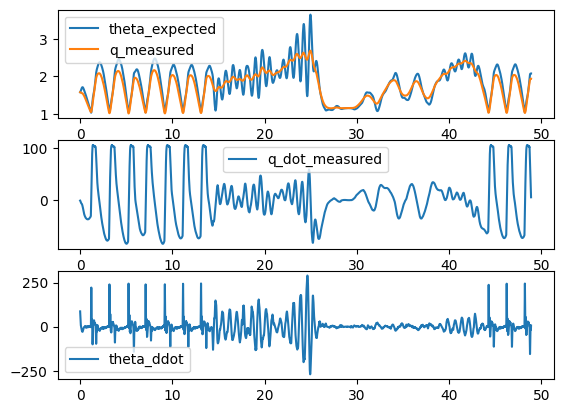

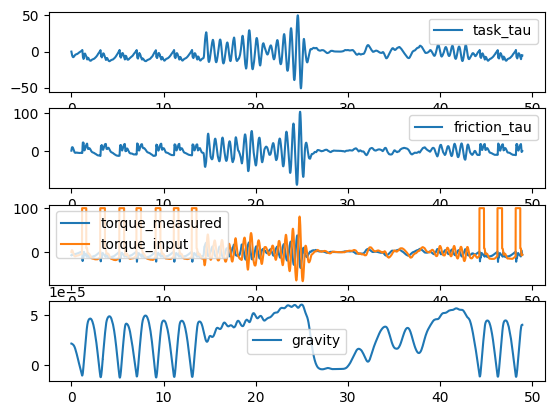

In [10]:
from kortex_api.autogen.client_stubs.ActuatorConfigClientRpc import ActuatorConfigClient
from kortex_api.autogen.client_stubs.ActuatorCyclicClientRpc import ActuatorCyclicClient
from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
from kortex_api.autogen.client_stubs.DeviceConfigClientRpc import DeviceConfigClient
from kortex_api.autogen.client_stubs.DeviceManagerClientRpc import DeviceManagerClient
from kortex_api.autogen.messages import Session_pb2, ActuatorConfig_pb2, Base_pb2, BaseCyclic_pb2, Common_pb2
from kortex_api.RouterClient import RouterClientSendOptions
from kortex_api.autogen.client_stubs.ControlConfigClientRpc import ControlConfigClient

from pathlib import Path
import sys
curr_path = Path().resolve()
sys.path.append(str(curr_path))
from impedance_ctrl_testing import SpringMassOscillationModel
from tool_box_no_ros import get_realtime_q_qdot, LowPassFilter, get_realtime_torque
import utilities
# import copy
from copy import deepcopy

import numpy as np
np.set_printoptions(precision=4, suppress=True)


import time
import sys
import threading

p_model = SpringMassOscillationModel()

class TCPArguments:
    def __init__(self):
        self.ip = "192.168.0.10"
        self.username = "admin"
        self.password = "admin"

class TorqueExample:
    def __init__(self, router, router_real_time, Home_pose="L_Home", actuator_id = 7):

        # Maximum allowed waiting time during actions (in seconds)
        self.ACTION_TIMEOUT_DURATION = 20

        self.torque_amplification = 1.0  # Torque measure on last actuator is sent as a command to first actuator
        self.Home_pose = Home_pose

        # Create required services
        device_manager = DeviceManagerClient(router)
        
        self.actuator_config = ActuatorConfigClient(router)
        self.base = BaseClient(router)
        self.base_cyclic = BaseCyclicClient(router_real_time)
        self.control_config = ControlConfigClient(router)

        self.base_command = BaseCyclic_pb2.Command()
        self.base_feedback = BaseCyclic_pb2.Feedback()
        self.base_custom_data = BaseCyclic_pb2.CustomData()

        # Detect all devices
        device_handles = device_manager.ReadAllDevices()
        self.actuator_count = self.base.GetActuatorCount().count

        # Only actuators are relevant for this example
        for handle in device_handles.device_handle:
            if handle.device_type == Common_pb2.BIG_ACTUATOR or handle.device_type == Common_pb2.SMALL_ACTUATOR:
                self.base_command.actuators.add()
                self.base_feedback.actuators.add()

        # Change send option to reduce max timeout at 3ms
        self.sendOption = RouterClientSendOptions()
        self.sendOption.andForget = False
        self.sendOption.delay_ms = 0
        self.sendOption.timeout_ms = 3

        self.cyclic_t_end = 30  #Total duration of the thread in seconds. 0 means infinite.
        self.cyclic_thread = {}

        self.kill_the_thread = False
        self.already_stopped = False
        self.cyclic_running = False

        # joint in control
        self.device_id = actuator_id

        # Store the torque values
        self.time_stamp_sec = []
        self.first_link_torque = []

        # store impedance result parameters
        self._theta = []
        self._theta_dot = []
        self._theta_ddot = []
        self._theta_des = []
        self._q = []
        self._q_dot = []

        self._tau = []
        self._gravity = []
        self._computation_time = []
        self._filtered_tau = []
        self._task_tau = []
        self._friction_tau = []

        # parameters for impedance control based on https://github.com/empriselab/gen3_compliant_controllers/blob/main/media/controller_formulation.pdf
        self.motor_joint_stiffness = np.diag([4000, 4000, 4000, 4000, 3500, 3500, 3500]) # Nm/rad
        self.motor_joint_Kp = 2.0* np.diag([20, 20, 20, 20, 10, 10, 10])  # motor joint stiffness gain
        # self.motor_joint_Kp = np.diag([40, 40, 40, 10, 5, 5, 5])  # motor joint stiffness gain (calibrated for compliance)

        self.motor_joint_Kd = np.diag([2, 2, 2, 2, 2, 2, 2])  # motor joint damping gain

        # self.motor_inertia = np.diag([0.3, 0.3, 0.3, 0.3, 0.18, 0.18, 0.18])  # kg.m^2
        self.motor_inertia = np.diag([0.08, 0.08, 0.08, 0.08, 0.10, 0.10, 0.10])  # kg.m^2

        self.motor_friction_l = 3.0 * np.diag([25, 25, 25, 25, 20, 20, 20]) # friction observor velocity gain 
        # self.motor_friction_l = np.diag([75, 75, 75, 75, 50, 50, 50]) # friction observor position gain (calibrated for compliance)

        self.motor_friction_lp = 0.1* np.diag([2.5, 2.5, 2.5, 2.5, 2, 2, 2]) # friction observor position gain 
        # self.motor_friction_lp = np.diag([0.25, 0.25, 0.25, 0.25, 0.2, 0.2, 0.2]) # friction observor position gain (calibrated for compliance)

        self.joint_torque_limit = np.array([50, 50, 50, 50, 30, 30, 30])  # Nm soft limit

        # filter for torque measurement
        self.torque_lowpass = []

        # collision angle
        self.collision_angle = None

    # Create closure to set an event after an END or an ABORT
    def check_for_end_or_abort(self, e):
        """Return a closure checking for END or ABORT notifications

        Arguments:
        e -- event to signal when the action is completed
            (will be set when an END or ABORT occurs)
        """
        def check(notification, e = e):
            print("EVENT : " + \
                Base_pb2.ActionEvent.Name(notification.action_event))
            if notification.action_event == Base_pb2.ACTION_END \
            or notification.action_event == Base_pb2.ACTION_ABORT:
                e.set()
        return check

    def MoveToHomePosition(self):
        # Make sure the arm is in Single Level Servoing mode
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
    
        # Move arm to ready position
        print("Moving the arm to a safe position")
        action_type = Base_pb2.RequestedActionType()
        action_type.action_type = Base_pb2.REACH_JOINT_ANGLES
        action_list = self.base.ReadAllActions(action_type)
        action_handle = None
        for action in action_list.action_list:
            # if action.name == "L_Home":
            if action.name == self.Home_pose:
                action_handle = action.handle

        if action_handle == None:
            print("Can't reach safe position. Exiting")
            return False

        e = threading.Event()
        notification_handle = self.base.OnNotificationActionTopic(
            self.check_for_end_or_abort(e),
            Base_pb2.NotificationOptions()
        )

        self.base.ExecuteActionFromReference(action_handle)

        print("Waiting for movement to finish ...")
        finished = e.wait(self.ACTION_TIMEOUT_DURATION)
        self.base.Unsubscribe(notification_handle)

        if finished:
            print("Cartesian movement completed")
        else:
            print("Timeout on action notification wait")
        return finished


    def InitCyclic(self, sampling_time_cyclic=0.001, t_end=30, print_stats=False, target_func=None):

        if self.cyclic_running:
            return True

        # Move to Home position first
        if not self.MoveToHomePosition():
            return False

        print("Init Cyclic")
        sys.stdout.flush()

        base_feedback = self.SendCallWithRetry(self.base_cyclic.RefreshFeedback, 3)
        if base_feedback:
            self.base_feedback = base_feedback

            # Init command frame
            for x in range(self.actuator_count):
                self.base_command.actuators[x].flags = 1  # servoing
                self.base_command.actuators[x].position = self.base_feedback.actuators[x].position

            # First actuator is going to be controlled in torque
            # To ensure continuity, torque command is set to measure
            self.base_command.actuators[0].torque_joint = self.base_feedback.actuators[0].torque

            # Set arm in LOW_LEVEL_SERVOING
            base_servo_mode = Base_pb2.ServoingModeInformation()
            base_servo_mode.servoing_mode = Base_pb2.LOW_LEVEL_SERVOING
            self.base.SetServoingMode(base_servo_mode)

            # Send first frame
            self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)

            # Set first actuator in torque mode now that the command is equal to measure
            control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
            control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('TORQUE')
            # self.device_id = 3  # first actuator as id = 1

            self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)

            # Init cyclic thread
            self.cyclic_t_end = t_end
            self.cyclic_thread = threading.Thread(target=target_func, args=(sampling_time_cyclic, print_stats))
            self.cyclic_thread.daemon = True
            self.cyclic_thread.start()
            return True

        else:
            print("InitCyclic: failed to communicate")
            return False


    def StopCyclic(self):
        print ("Stopping the cyclic and putting the arm back in position mode...")
        if self.already_stopped:
            return

        # Kill the  thread first
        if self.cyclic_running:
            self.kill_the_thread = True
            self.cyclic_thread.join()
        
        # Set first actuator back in position mode
        control_mode_message = ActuatorConfig_pb2.ControlModeInformation()
        control_mode_message.control_mode = ActuatorConfig_pb2.ControlMode.Value('POSITION')
        # self.device_id = 1  # first actuator has id = 1
        self.SendCallWithRetry(self.actuator_config.SetControlMode, 3, control_mode_message, self.device_id)
        
        base_servo_mode = Base_pb2.ServoingModeInformation()
        base_servo_mode.servoing_mode = Base_pb2.SINGLE_LEVEL_SERVOING
        self.base.SetServoingMode(base_servo_mode)
        self.cyclic_t_end = 0.1

        self.already_stopped = True
        
        print('Clean Exit')

    @staticmethod
    def SendCallWithRetry(call, retry,  *args):
        i = 0
        arg_out = []
        while i < retry:
            try:
                arg_out = call(*args)
                break
            except:
                i = i + 1
                continue
        if i == retry:
            print("Failed to communicate")
        return arg_out
    

    def max_torque_braking(self, t_sample, print_stats):
        self.cyclic_running = True
        print("Run Cyclic")
        sys.stdout.flush()
        cyclic_count = 0
        stats_count = 0
        failed_cyclic_count = 0

        t_now = time.time()
        t_cyclic = t_now
        t_stats = t_now
        t_init = t_now

        # init_theta = self.base_feedback.actuators[self.device_id-1].position
        init_q, init_qdot = get_realtime_q_qdot(self.base_feedback)
        init_torque = get_realtime_torque(self.base_feedback)
        
        previous_nominal_theta = init_q # nominal motor angle
        previous_nominal_theta_dot = init_qdot  # nominal motor velocity

        K_s_inv = np.linalg.inv(self.motor_joint_stiffness)
        K_r_inv = np.linalg.inv(self.motor_inertia) # motor inertia

    
        self.torque_lowpass = LowPassFilter(init_torque,cutoff_freq=10)
        self.velocity_lowpass = LowPassFilter(init_qdot, cutoff_freq=10)
        #Initialization was incorrect. with multi channel

        self.max_torque_on = False

        print("Running friction compensation for {} seconds".format(self.cyclic_t_end))

        while not self.kill_the_thread:
            t_now = time.time()

            if (t_now - t_cyclic) >= t_sample: # 1ms
                t_cyclic = t_now
                # Position command to avoid following error
                self.base_command.actuators[self.device_id-1].position = self.base_feedback.actuators[self.device_id-1].position

                # get the current joint angle and velocity for pinocchio model
                q, qdot_raw = get_realtime_q_qdot(self.base_feedback)
                qdot = self.velocity_lowpass.filter(qdot_raw)


                q_pin = p_model.standard_to_pinocchio(q)
                M, C, G = p_model.get_robot_dynamics(q_pin, qdot)
                # notice that G is the force that the motor needs to apply to counteract gravity not the gravity itself
                g_actuator = G[self.device_id-1]
                self._gravity.append(g_actuator)

                # get torque measurement
                tau_full = get_realtime_torque(self.base_feedback)
                tau_full = self.torque_lowpass.filter(tau_full)
                tau_measured = self.base_feedback.actuators[self.device_id-1].torque
                tau_filtered = tau_full[self.device_id-1]

                #### with target impedance #####
                # q_des = deepcopy(init_q)
                # q_des[self.device_id-1] = 1.0  # rad

                ##### Compliant control #####
                q_des = q



                qdot_des = qdot

                # setting up friction observer
                # print(f"gravity effect on theta_des: {K_s_inv @ G}")
                theta_des = q_des - K_s_inv @ G
                theta_dot_des = qdot_des
                # print(f"theta_des, theta_dot_des: {theta_des[0]}, {theta_dot_des[0]}")

                # print(f"prev_n_theta, theta_des, prev_n_theta_dot, theta_dot_des: {previous_nominal_theta[0]}, {theta_des[0]}, {previous_nominal_theta_dot[0]}, {theta_dot_des[0]}")
                # handling the angle difference at boundaries
                theta_diff = (previous_nominal_theta - theta_des + np.pi) % (2 * np.pi) - np.pi  # wrap to -pi to pi
                # print(f"theta_diff: {theta_diff[self.device_id-1]}")

                tau_task = -self.motor_joint_Kp @ (theta_diff) - self.motor_joint_Kd @ (previous_nominal_theta_dot - theta_dot_des)
                nominal_theta_ddot = K_r_inv @ (tau_task - G - tau_full)
                nominal_theta_dot = previous_nominal_theta_dot + t_sample * nominal_theta_ddot
                nominal_theta = previous_nominal_theta + t_sample * nominal_theta_dot
                # print(f"tau_task, nthdd, nthd, nth: {tau_task[0]}, {nominal_theta_ddot[0]}, {nominal_theta_dot[0]}, {nominal_theta[0]}")

                # update previous values
                previous_nominal_theta = nominal_theta
                previous_nominal_theta_dot = nominal_theta_dot

                # nominal friction
                # print(f"n_th_d, qdot, n_th, q: {nominal_theta_dot[0]}, {qdot[0]}, {nominal_theta[0]}, {q[0]}")
                # handling the angle difference at boundaries
                observer_theta_diff = (nominal_theta - q + np.pi) % (2 * np.pi) - np.pi
                tau_friction = self.motor_inertia @ self.motor_friction_l @ ((nominal_theta_dot - qdot) + self.motor_friction_lp @ (observer_theta_diff))
                # print(f"task, friction, ddot, dot, theta: {tau_task[0]}, {tau_friction[0]}, {nominal_theta_ddot[0]}, {nominal_theta_dot[0]}, {nominal_theta[0]}")
                # tau = tau_task + tau_friction


                # # log torque and time
    
                self._theta.append(nominal_theta)
                self._theta_dot.append(nominal_theta_dot*180/np.pi)
                self._theta_des.append(theta_des)
                self._theta_ddot.append(nominal_theta_ddot)
                self._q.append(q)
                self._q_dot.append(qdot*180/np.pi)
                self._filtered_tau.append(tau_full)
                
                self._task_tau.append(tau_task)
                self._friction_tau.append(tau_friction)



                # need to remove the torque measured from the actuation
                # input_torque = (self.base_feedback.actuators[self.device_id-1].torque + G[self.device_id-1])

                ################## observer friction compensation#####################
                input_torque = tau_task[self.device_id-1] + tau_friction[self.device_id-1] + G[self.device_id-1] # Nm
                
                # input_torque = np.clip(input_torque, -self.joint_torque_limit[self.device_id-1], self.joint_torque_limit[self.device_id-1])


                if q[self.device_id-1] > np.radians(100):
                    self.max_torque_on = False


                # switch to max torque when the joint value satisfy the following condition
                if q[self.device_id-1] < np.radians(60):
                    self.max_torque_on = True
                if self.max_torque_on:
                    input_torque = 100.0  # Nm


                self.base_command.actuators[self.device_id-1].torque_joint = input_torque
                self._tau.append(input_torque)

                # print("meas, task, friction, grav: ", tau_measured, tau_task[self.device_id-1], tau_friction[self.device_id-1], g_actuator)
            

                # Incrementing identifier ensure actuators can reject out of time frames
                self.base_command.frame_id += 1
                if self.base_command.frame_id > 65535:
                    self.base_command.frame_id = 0
                for i in range(self.actuator_count):
                    self.base_command.actuators[i].command_id = self.base_command.frame_id

                # Frame is sent
                try:
                    self.base_feedback = self.base_cyclic.Refresh(self.base_command, 0, self.sendOption)
                except:
                    failed_cyclic_count = failed_cyclic_count + 1
                cyclic_count = cyclic_count + 1
                self.time_stamp_sec.append(t_now-t_init)
                self._computation_time.append(time.time()-t_now)

            # Stats Print
            if print_stats and ((t_now - t_stats) > 1):
                t_stats = t_now
                stats_count = stats_count + 1
                
                cyclic_count = 0
                failed_cyclic_count = 0
                sys.stdout.flush()

            if self.cyclic_t_end != 0 and (t_now - t_init > self.cyclic_t_end):
                print("Cyclic Finished")
                sys.stdout.flush()
                break
        self.cyclic_running = False
        return True


import matplotlib.pyplot as plt

args = TCPArguments()
t_log = []
torque_log = []
# Create connection to the device and get the router
with utilities.DeviceConnection.createTcpConnection(args) as router, utilities.DeviceConnection.createUdpConnection(args) as router_real_time:

    torque_example = TorqueExample(router, router_real_time, Home_pose="L_Home", actuator_id= 1)
    # torque_example = TorqueExample(router, router_real_time, Home_pose="L_Back", actuator_id= 3)


    success = torque_example.InitCyclic(0.001, 60, True, torque_example.max_torque_braking)
    if success:
        while torque_example.cyclic_running:
            try:
                time.sleep(0.1)
            except KeyboardInterrupt:
                break

        torque_example.StopCyclic()
        t_log = torque_example.time_stamp_sec
        torque_log = torque_example._tau


# # plot the torque
# plt.plot(t_log, torque_log, label="torque_sensed")
# plt.plot(t_log, torque_example._filtered_tau, label="torque_filtered")
# plt.plot(t_log, torque_example._computation_time, label="computation_time")
# plt.plot(t_log, torque_example._gravity, label="gravity_compensation")
# plt.legend()
dev_id = torque_example.device_id
print(f"device_id: {dev_id}")
# # another plot with subplots
fig, axs = plt.subplots(3, 1)
axs[0].plot(t_log, np.array(torque_example._theta).T[dev_id-1], label="theta_expected")
axs[0].plot(t_log, np.array(torque_example._q).T[dev_id-1], label="q_measured")
axs[0].legend()
# axs[1].plot(t_log, np.array(torque_example._theta_dot).T[dev_id-1], label="theta_dot_expected")
axs[1].plot(t_log, np.array(torque_example._q_dot).T[dev_id-1], label="q_dot_measured")
axs[1].legend()
axs[2].plot(t_log, np.array(torque_example._theta_ddot).T[dev_id-1], label="theta_ddot")
axs[2].legend()

# another plot for task and friction torque
fig, axs = plt.subplots(4, 1)
axs[0].plot(t_log, np.array(torque_example._task_tau).T[dev_id-1], label="task_tau")
axs[0].legend()
axs[1].plot(t_log, np.array(torque_example._friction_tau).T[dev_id-1], label="friction_tau")
axs[1].legend()
axs[2].plot(t_log, np.array(torque_example._filtered_tau).T[dev_id-1], label="torque_measured")
axs[2].plot(t_log, np.array(torque_example._tau), label="torque_input")
axs[2].legend()
axs[3].plot(t_log, torque_example._gravity, label="gravity")
axs[3].legend()
